# Local Homology NLP Use Cases: Unsupervised text disambiguation

In this tutorial we use tools from Topological Data Analysis (TDA) to study the local geometry of point clouds. 

In [2]:
from gtda.plotting import plot_point_cloud
from local_simplicial import *
import numpy as np

Recent research have been looking at the the role of local homology in Natural Language Processing, and particularly to the task of text dissamgibuating'. Here we showcase a method that can be useful to distinguish occurences of the word "note" when referring to a musical "note", versus when used as a word referring to text.

In [14]:
# Import needed libraries
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.parsing.preprocessing import remove_stopwords, stem

In [15]:
# Preprocess the data
f = open("Data/note.n.xml","r")
content = f.read()
temp_list = content.split("<note.n.")
list_of_text = list(map(remove_stopwords,temp_list)) # remove stopwords
list_of_text = list(map(stem, temp_list)) # make lower case
refined_list = [list_of_text[i][1+len(str(i)):-12 - len(str(i))] for i in range(2,len(list_of_text))]

In [5]:
# In order to interpret the persistence diagram, we introduce some helper functions:
from gtda.diagrams.features import PersistenceEntropy

def modified_persistence_entropy(diags):
    """ This is a custom vectorizer, similar to functions
    in gtda.diagrams.features. Inputs a sequence of persistence
    diagrams, and outputs a sequence of vectors"""
    return 2**PersistenceEntropy().fit_transform(diags)

def plot_coloured_cloud(local_hom, diags, point_cloud, dimension):
    """ This is a custom plotting function, that plots the point cloud and colours 
     the points according to their persistence diagrams in the given dimension"""
    dim_index = np.argwhere(np.array(local_hom.homology_dimensions)==dimension)[0][0]
    dim_vects = modified_persistence_entropy(diags) #Modified this to not store diags
    return plot_point_cloud(point_cloud,
                            plotly_params={"trace" : {"marker": {"color":dim_vects[:, dim_index],
                                                                 "size":6,
                                                                 "showscale":True}, 
                                                     "text":['color: '+str(i) for i in dim_vects[:, dim_index]]}
                                          })

In [6]:
# extract sentences and vectorize them
all_words_in_sentences = list(map(str.split,refined_list))
word2vec = Word2Vec(sentences=all_words_in_sentences, vector_size=30, window=5, min_count=1, workers=4)

# list of array with vectorized snipet
list_of_vect_sentences = [word2vec.wv[all_words_in_sentences[i]] for i in range(len(all_words_in_sentences))]

# initialize the local homology transformer
lh = KNeighborsLocalVietorisRips(n_neighbors=(5, 15), homology_dimensions=(1,2), n_jobs = -1)

In [7]:
# example of a preprocessed sentence where "note" is used as a verb
print(refined_list[0])
lh.fit(list_of_vect_sentences[0])
modified_persistence_entropy(lh.transform(np.array([word2vec.wv["note"]], dtype=float)))

one of the properti is a print history. thi will detail the most recent print activ concern the file ( although it onli record the print request , it is not absolut proof that a print wa actual produc ) . note that it onli allow a maximum of 250 charact and mai therefor not provid a complet history; in the event of the histori exceed thi volum , it can onli guarante detail of the most recent activ 


array([[0.5, 0.5]])

In [8]:
# example of preprocessed sentence where "note" refers to music
print(refined_list[1])
lh.fit(list_of_vect_sentences[1])
modified_persistence_entropy(lh.transform(np.array([word2vec.wv["note"]], dtype=float)))

lack absolut pitch , most of us ca n't make that connection-label a note as " d " , for example. but do the connect and label get hammer in dure music lesson , or ar some babi just born with a flair for identifi pitch ? that 's a hard question to answer , sinc music parent often pass a passion for music-a well as their genes-on to their children 


array([[3.53714141, 0.5       ]])

In [9]:
# Imports that will help us visualize the data
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import umap

Note is at the 41th position.
Preprocessed sentence: 
one of the properti is a print history. thi will detail the most recent print activ concern the file ( although it onli record the print request , it is not absolut proof that a print wa actual produc ) . note that it onli allow a maximum of 250 charact and mai therefor not provid a complet history; in the event of the histori exceed thi volum , it can onli guarante detail of the most recent activ 
First and second Betti numbers:
[[0.5 0.5]]


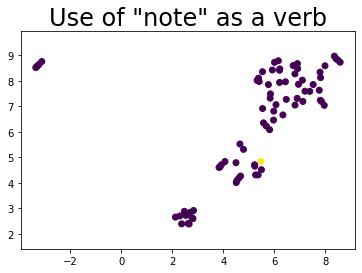

In [10]:
# Note as a verb

i=0 
value = None
# for loop to find the instance of note
for k in range(len(list_of_vect_sentences[i])):
    if (list_of_vect_sentences[i][k] == word2vec.wv["note"]).all():
        value = k
temp = np.zeros((len(list_of_vect_sentences[i])))
temp[value] = 1
print("Note is at the " + str(value) + "th position.")

reducer = umap.UMAP()

scaled_point_cloud = StandardScaler().fit_transform(list_of_vect_sentences[i])

embedding = reducer.fit_transform(scaled_point_cloud)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c = temp)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Use of "note" as a verb', fontsize=24)

# Example of sentence has "note" in it used as the verb
print("Preprocessed sentence: ")
print(refined_list[i])
lh.fit(list_of_vect_sentences[i])

print("First and second Betti numbers:")
print(modified_persistence_entropy(lh.transform(np.array([word2vec.wv["note"]], dtype=float))))

plt.savefig('verb_note.png')

Note is at the 13th position.
Preprocessed sentence: 
lack absolut pitch , most of us ca n't make that connection-label a note as " d " , for example. but do the connect and label get hammer in dure music lesson , or ar some babi just born with a flair for identifi pitch ? that 's a hard question to answer , sinc music parent often pass a passion for music-a well as their genes-on to their children 
First and second Betti numbers:
[[3.53714141 0.5       ]]


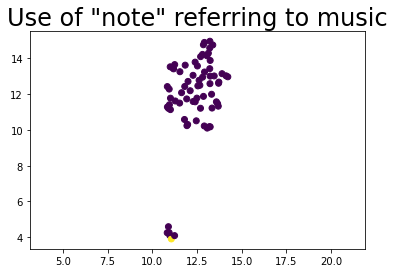

In [11]:
# Musical note
i=1
value=None
for k in range(len(list_of_vect_sentences[i])):
    if (list_of_vect_sentences[i][k] == word2vec.wv["note"]).all():
        value = k
temp = np.zeros((len(list_of_vect_sentences[i])))
temp[value] = 1

print("Note is at the " + str(value) + "th position.")

reducer = umap.UMAP()
scaled_point_cloud = StandardScaler().fit_transform(list_of_vect_sentences[i])

embedding = reducer.fit_transform(scaled_point_cloud)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c = temp)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Use of "note" referring to music', fontsize=24)

i=1
# This one uses the musical note
print("Preprocessed sentence: ")
print(refined_list[i])
lh.fit(list_of_vect_sentences[i])

print("First and second Betti numbers:")
print(modified_persistence_entropy(lh.transform(np.array([word2vec.wv["note"]], dtype=float))))

plt.savefig('music_note.png')